# Library Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Import Datasets

In [3]:
train_csv_url = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-10/train.csv"
valid_csv_url = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-10/valid.csv"
test_csv_url = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-10/test.csv"

train_data = pd.read_csv(train_csv_url)
valid_data = pd.read_csv(valid_csv_url)
test_data = pd.read_csv(test_csv_url)

print("Train data:")
print(train_data.head())
print("Valid data:")
print(valid_data.head())
print("Test data:")
print(test_data.head())

Train data:
   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  -0.027083   0.072947  -0.093659   0.053418  -0.085516  -0.102610   
1   0.070195   0.228641  -0.132860  -0.077761  -0.054993  -0.210365   
2   0.164312   0.052808  -0.058510   0.104724  -0.025886  -0.101427   
3   0.029730   0.113737   0.061113  -0.099329  -0.111600  -0.245942   
4   0.031364   0.142409  -0.160743  -0.076594  -0.062412  -0.264732   

   feature_7  feature_8  feature_9  feature_10  ...  feature_763  feature_764  \
0  -0.021217   0.016162  -0.184269    0.110335  ...    -0.183643     0.091299   
1   0.127747  -0.132385  -0.161366    0.172764  ...    -0.123668     0.029626   
2  -0.047177   0.091298  -0.094569    0.088062  ...     0.075410     0.070125   
3   0.086520   0.071996   0.028319    0.207910  ...    -0.062511    -0.226912   
4   0.079197   0.026060  -0.217023    0.084656  ...    -0.193882     0.107297   

   feature_765  feature_766  feature_767  feature_768  label_1  label_2  \

# Data Visualization

In [ ]:
def visualize_label(y, title, x_title, y_title='Number of entries'):
  unique_classes, class_counts = np.unique(y, return_counts=True)
  plt.bar(unique_classes, class_counts)
  plt.xlabel(x_title)
  plt.ylabel(y_title)
  plt.title(title)
  plt.show()

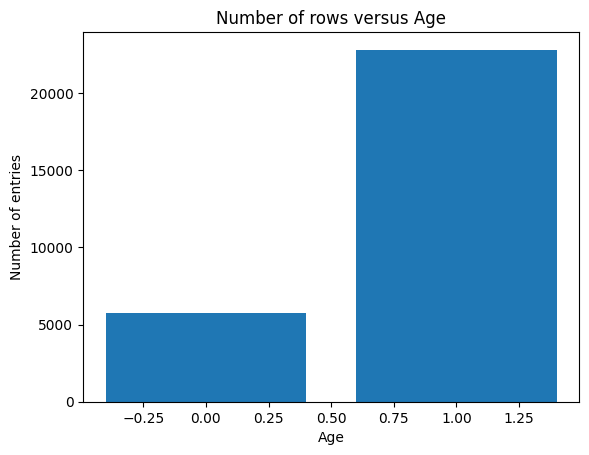

In [ ]:
visualize_label(train_data['label_3'], "Number of rows versus Age","Age")

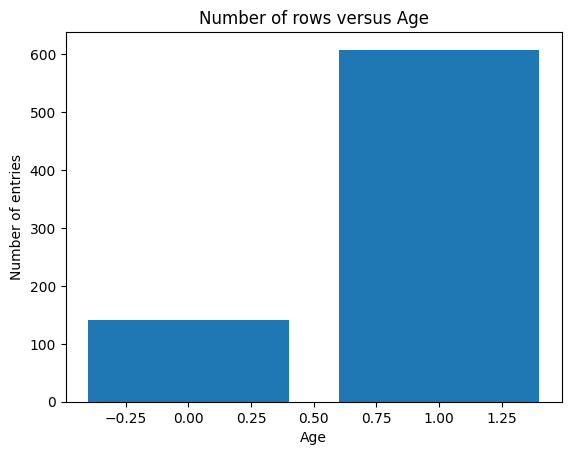

In [ ]:
visualize_label(valid_data['label_3'], "Number of rows versus Age","Age")

# Outlier Detection and Removal

In [4]:
from scipy.stats import norm

def visualize_label_norm(y, title, x_title, y_title='Number of entries'):
  unique_classes, class_counts = np.unique(y, return_counts=True)
  plt.bar(unique_classes, class_counts)
  plt.xlabel(x_title)
  plt.ylabel(y_title)
  plt.title(title)

  rng = np.arange(train_data["label_3"].min(), train_data["label_3"].max(), 0.1)
  plt.plot(rng, norm.pdf(rng,train_data["label_3"].mean(),train_data["label_3"].std()))
  plt.show()

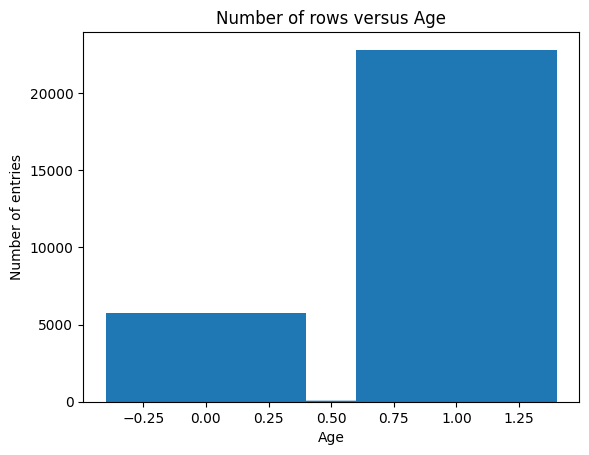

In [5]:
visualize_label_norm(train_data['label_3'], "Number of rows versus Age","Age")

In [6]:
train_data['zscore'] = ( train_data["label_3"] - train_data["label_3"].mean() ) / train_data["label_3"].std()
outliers = train_data[(train_data.zscore<-3) | (train_data.zscore>3)]
outliers.shape

(0, 773)

No outliers to remove

# Train without Feaure Reduction

In [7]:
print(f"train_data dataset shape {train_data.shape}")
print(f"# of missing values {train_data['label_3'].isna().sum()}")
print(f"# of labels {train_data['label_3'].value_counts().shape[0]}")
print(f"label summary\n{train_data['label_3'].value_counts()}")

train_data dataset shape (28520, 773)
# of missing values 0
# of labels 2
label summary
1    22796
0     5724
Name: label_3, dtype: int64


In [8]:
train_data.dropna(subset=['label_3'], inplace=True)
print(f"train_data dataset shape {train_data.shape}")

train_data dataset shape (28520, 773)


Feature Enginering

*   Label_3 has no missing values
*   Label_3 has 2 unique classes
*   Using one-hot encoding for multilabel classification



In [9]:
label_3 = train_data['label_3'].values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(label_3)
print(ohe.categories_)

label_3 = ohe.transform(label_3)
print(label_3)

[array([0, 1])]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(train_data.iloc[:, :768], label_3, test_size=0.2, stratify=label_3, random_state=2023)

In [11]:
X_train_tensors = torch.tensor(X_train.iloc[:, :].values, dtype=torch.float32)
print(X_train_tensors.shape)

X_test_tensors = torch.tensor(X_test.iloc[:, :].values, dtype=torch.float32)
print(X_test_tensors.shape)

torch.Size([22816, 768])
torch.Size([5704, 768])


## Define the Model

In [12]:
class GenderClassifier(nn.Module):
    def __init__(self, dropout_prob=0.5, weight_decay=1e-5):
        super(GenderClassifier, self).__init__()
        self.linear1 = nn.Linear(768, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 2)

        # Set weight_decay for regularization
        self.weight_decay = weight_decay

    def forward(self, tensors):
        output_l1 = torch.relu(self.linear1(tensors))
        output_l2 = torch.relu(self.linear2(output_l1))
        output_l3 = torch.relu(self.linear3(output_l2))
        output_l4 = self.linear4(output_l3)
        return output_l4

    def l2_regularization_loss(self):
        # Calculate L2 regularization loss for linear layers
        l2_loss = 0.0
        for param in self.parameters():
            if param.requires_grad:
                l2_loss += torch.norm(param, 2)
        return self.weight_decay * l2_loss

## Train the model

In [13]:
# Create an instance of the GenderClassifier model
genderClassifier = GenderClassifier()

# Define a cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Create a DataLoader for batching
batch_size = 128
dataset = TensorDataset(X_train_tensors, torch.tensor(y_train))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define an optimizer
optimizer = torch.optim.Adam(genderClassifier.parameters(), lr=0.0001)

# Define early stopping parameters
patience = 100
best_validation_accuracy = 0
no_improvement_counter = 0

# Training loop
epochs = 1000
for epoch in range(epochs):

    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = genderClassifier(inputs)

        ce_loss = criterion(outputs, targets)
        l2_loss = genderClassifier.l2_regularization_loss()

        total_loss = ce_loss + l2_loss

        total_loss.backward()
        optimizer.step()

    # Validation step (evaluate on validation dataset)
    with torch.no_grad():
        genderClassifier.eval()
        y_test_pred = genderClassifier(X_test_tensors)
        ce = criterion(y_test_pred, torch.tensor(y_test))
        acc = (torch.argmax(y_test_pred, 1) == torch.argmax(torch.tensor(y_test), 1)).float().mean()
        genderClassifier.train()

    print(f"Epoch {epoch} validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

    # Check for early stopping
    if acc > best_validation_accuracy:
        best_validation_accuracy = acc
        no_improvement_counter = 0
        # Save the trained best model if needed
        torch.save(genderClassifier.state_dict(), 'genderClassifier_model.pth')
    else:
        no_improvement_counter += 1

    # If no improvement for 'patience' consecutive epochs, stop training
    if no_improvement_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

Epoch 0 validation: Cross-entropy=0.08391678326101154, Accuracy=0.9761570692062378
Epoch 1 validation: Cross-entropy=0.0297930300321641, Accuracy=0.9893057346343994
Epoch 2 validation: Cross-entropy=0.028254169249431752, Accuracy=0.9900069832801819
Epoch 3 validation: Cross-entropy=0.01929480124313034, Accuracy=0.9936886429786682
Epoch 4 validation: Cross-entropy=0.017763301012858255, Accuracy=0.9949158430099487
Epoch 5 validation: Cross-entropy=0.017273759943046, Accuracy=0.9943898916244507
Epoch 6 validation: Cross-entropy=0.016440635910594588, Accuracy=0.9949158430099487
Epoch 7 validation: Cross-entropy=0.015876084429749797, Accuracy=0.9952664971351624
Epoch 8 validation: Cross-entropy=0.0168962344533113, Accuracy=0.9952664971351624
Epoch 9 validation: Cross-entropy=0.01980380330824702, Accuracy=0.9947405457496643
Epoch 10 validation: Cross-entropy=0.016417259956710162, Accuracy=0.9950911402702332
Epoch 11 validation: Cross-entropy=0.017966218377982124, Accuracy=0.9950911402702332


In [14]:
# Create an instance of the model
genderClassifier = GenderClassifier()

# Load the saved model state dictionary
genderClassifier.load_state_dict(torch.load('genderClassifier_model.pth'))

# Validation step (evaluate on validation dataset)
with torch.no_grad():
    genderClassifier.eval()
    y_test_pred = genderClassifier(X_test_tensors)
    ce = criterion(y_test_pred, torch.tensor(y_test))
    acc = (torch.argmax(y_test_pred, 1) == torch.argmax(torch.tensor(y_test), 1)).float().mean()

print(f"Best model validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

Best model validation: Cross-entropy=0.019245343622112304, Accuracy=0.9966689944267273


## Evaluation of the Model

In [15]:
valid_data.dropna(subset=['label_3'], inplace=True)
print(f"valid_data dataset shape {valid_data.shape}")

valid_data dataset shape (750, 772)


In [16]:
label_3_eval = valid_data['label_3'].values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(label_3_eval)
print(ohe.categories_)

label_3_eval = ohe.transform(label_3_eval)
print(label_3_eval)

[array([0, 1])]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [17]:
# Set your model to evaluation mode
genderClassifier.eval()

X_valid_tensors = torch.tensor(valid_data.iloc[:, :768].values, dtype=torch.float32)
print(X_valid_tensors.shape)

y_pred = genderClassifier(X_valid_tensors)
ce = criterion(y_pred, torch.tensor(label_3_eval))
acc = (torch.argmax(y_pred, 1) == torch.argmax(torch.tensor(label_3_eval), 1)).float().mean()
print(f"Cross-entropy={float(ce)}, Test Accuracy={float(acc)}")

torch.Size([750, 768])
Cross-entropy=0.010815580054717855, Test Accuracy=0.9946666955947876


In [18]:
y_pred_labels = torch.argmax(y_pred, axis=1).numpy()
label_3_np = torch.argmax(torch.tensor(label_3_eval), axis=1).numpy()

confusion = confusion_matrix(label_3_np, y_pred_labels)
print(classification_report(label_3_np, y_pred_labels))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       142
           1       1.00      1.00      1.00       608

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750



In [19]:
accuracy_score(label_3_np, y_pred_labels)

0.9946666666666667

## Get Test Results

In [20]:
# Set your model to evaluation mode
genderClassifier.eval()

X_t_tensors = torch.tensor(test_data.iloc[:, :768].values, dtype=torch.float32)
print(X_t_tensors.shape)

y_pred_t = genderClassifier(X_t_tensors)
print(y_pred_t.shape)


torch.Size([744, 768])
torch.Size([744, 2])


In [21]:
y_pred_one_hot = ohe.inverse_transform(y_pred_t.detach().numpy())
test_data["label_3"] = pd.DataFrame(y_pred_one_hot, columns=["label_3"])

In [22]:
test_data.head()

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768,label_3
0,1,-0.063023,0.085030,-0.057909,0.024293,0.028695,-0.113796,0.028477,-0.006041,-0.132434,...,0.078897,0.120168,-0.160152,-0.200884,0.046231,-0.115850,0.182974,0.047106,-0.118783,1
1,2,-0.036403,0.115930,-0.066521,0.045771,-0.027250,-0.164679,0.023611,0.056512,-0.171498,...,0.042576,0.006788,-0.207013,-0.205184,-0.053462,-0.003775,-0.035003,-0.041118,-0.079211,1
2,3,0.030672,0.045321,-0.163811,0.142376,-0.125894,-0.083943,-0.039693,-0.004867,-0.127951,...,0.038063,0.070423,-0.253409,-0.072147,0.016236,-0.144047,-0.122405,-0.063079,-0.188233,1
3,4,-0.000984,0.080593,-0.067086,0.005251,-0.141851,-0.125211,-0.016161,0.106323,-0.203491,...,0.028166,-0.073713,-0.073180,-0.109380,-0.027901,-0.006863,0.016840,-0.171139,0.086868,1
4,5,0.059806,0.088846,-0.058021,0.133098,-0.083380,-0.026724,-0.033793,-0.004055,-0.057890,...,0.026333,0.012204,-0.245772,-0.044506,0.058273,-0.005203,-0.104552,0.002035,-0.091528,1


In [23]:
file_path = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-10/label_3.csv"

# Save the DataFrame to a CSV file
test_data.to_csv(file_path, index=False)

# Train with Feature Engineering

In [ ]:
data_features = train_data.iloc[:, :768]

## Drop Constant Features Using Variance Threshold

In [ ]:
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(data_features)

VarianceThreshold(threshold=0)

In [ ]:
constant_columns = [column for column in data_features.columns
                    if column not in data_features.columns[var_thres.get_support()]]

print(constant_columns)

[]


There is no constant columns

## Drop Features Using Pearson Correlation

In [ ]:
data_features.corr()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768
feature_1,1.000000,0.267338,0.071490,0.414422,0.036982,0.207898,0.118319,0.147709,0.368570,-0.190114,...,0.294503,0.016181,0.253096,-0.245060,0.423731,0.443474,0.216448,-0.372152,0.081136,0.266223
feature_2,0.267338,1.000000,-0.027042,0.004284,0.009556,-0.175189,0.118727,0.047381,0.146719,0.004041,...,0.036397,0.120084,0.058233,-0.095840,0.066372,0.357378,0.107098,0.008878,-0.021500,0.233835
feature_3,0.071490,-0.027042,1.000000,0.005692,0.187217,-0.184922,-0.071054,-0.217118,0.112494,-0.045269,...,-0.054550,0.048824,-0.087434,0.183482,-0.184763,-0.133512,-0.018046,0.164799,-0.030219,0.204483
feature_4,0.414422,0.004284,0.005692,1.000000,-0.017515,0.295999,-0.119338,0.077402,0.123430,-0.147437,...,0.402941,-0.048514,0.175835,-0.130880,0.364475,0.317812,0.156064,-0.313222,0.200493,0.071073
feature_5,0.036982,0.009556,0.187217,-0.017515,1.000000,-0.139041,-0.020940,-0.116694,0.187147,-0.095713,...,0.002091,0.094546,0.062270,0.143789,-0.263428,0.032675,-0.091599,0.159690,-0.051591,-0.072895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_764,0.443474,0.357378,-0.133512,0.317812,0.032675,0.202273,0.078858,0.117481,0.085433,-0.282476,...,0.192540,0.068779,0.145485,-0.230508,0.315251,1.000000,0.204746,-0.159590,0.181170,0.216180
feature_765,0.216448,0.107098,-0.018046,0.156064,-0.091599,-0.113032,-0.079667,0.106025,0.118023,-0.205155,...,0.213167,0.136531,0.093549,-0.129885,0.327689,0.204746,1.000000,-0.117247,0.154951,0.388355
feature_766,-0.372152,0.008878,0.164799,-0.313222,0.159690,-0.411833,-0.139678,-0.374096,-0.342061,0.119664,...,-0.559327,0.201898,-0.053654,0.334765,-0.503721,-0.159590,-0.117247,1.000000,-0.224632,0.129305
feature_767,0.081136,-0.021500,-0.030219,0.200493,-0.051591,0.173833,-0.109424,0.160097,0.017900,-0.064848,...,0.242810,-0.086578,-0.004117,-0.247390,0.280897,0.181170,0.154951,-0.224632,1.000000,0.043913


In [ ]:
# Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data_features.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [ ]:
def correlation(dataset, threshold):
    correlated_pairs = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                rowname = corr_matrix.index[j]  # getting the name of row
                correlated_pairs.add((rowname, colname))
    return correlated_pairs

def get_less_correlated_features(correlated_pairs, dataset, target_column):
    less_correlated_features = {}

    for (feature1, feature2) in correlated_pairs:
        corr1 = dataset[feature1].corr(dataset[target_column])
        corr2 = dataset[feature2].corr(dataset[target_column])

        if abs(corr1) < abs(corr2):
            correlated_pair = frozenset((feature1, feature2))  # Use a frozenset as the key
            less_correlated_features[correlated_pair] = feature1
        else:
            correlated_pair = frozenset((feature1, feature2))  # Use a frozenset as the key
            less_correlated_features[correlated_pair] = feature2

    return less_correlated_features

In [ ]:
corr_feature_pairs = correlation(data_features, 0.9)
corr_feature_pairs

set()

In [ ]:
less_correlated_features = get_less_correlated_features(corr_feature_pairs, train_data, "label_3")
less_correlated_features

{}

In [ ]:
corr_features = set(less_correlated_features.values())
corr_features

set()

In [ ]:
new_features = data_features.drop(corr_features,axis=1)

In [ ]:
print(data_features.shape)
print(new_features.shape)

(28520, 768)
(28520, 767)


## Train the model

In [ ]:
class GenderClassifierAfter(nn.Module):
    def __init__(self, dropout_prob=0.5, weight_decay=1e-5):
        super(GenderClassifierAfter, self).__init__()
        self.linear1 = nn.Linear(767, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, 2)

        # Set weight_decay for regularization
        self.weight_decay = weight_decay

    def forward(self, tensors):
        output_l1 = torch.relu(self.linear1(tensors))
        output_l2 = torch.relu(self.linear2(output_l1))
        output_l3 = torch.relu(self.linear3(output_l2))
        output_l4 = self.linear4(output_l3)
        return output_l4

    def l2_regularization_loss(self):
        # Calculate L2 regularization loss for linear layers
        l2_loss = 0.0
        for param in self.parameters():
            if param.requires_grad:
                l2_loss += torch.norm(param, 2)
        return self.weight_decay * l2_loss

In [ ]:
label_3 = train_data['label_3'].values.reshape(-1, 1)
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(label_3)
print(ohe.categories_)

label_3 = ohe.transform(label_3)
print(label_3)

[array([0, 1])]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
X_train_after, X_test_after, y_train_after, y_test_after = train_test_split(new_features, label_3, test_size=0.2, stratify=label_3, random_state=2023)

X_train_tensors_after = torch.tensor(X_train_after.values, dtype=torch.float32)
print(X_train_tensors_after.shape)


X_test_tensors_after = torch.tensor(X_test_after.values, dtype=torch.float32)
print(X_test_tensors_after.shape)

torch.Size([22816, 767])
torch.Size([5704, 767])


In [ ]:
y_train_after.shape

(22816, 2)

In [ ]:
# Create an instance of the GenderClassifierAfter model
genderClassifierAfter = GenderClassifierAfter()

# Define a cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Create a DataLoader for batching
batch_size = 128
dataset = TensorDataset(X_train_tensors_after, torch.tensor(y_train_after))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define an optimizer
optimizer = torch.optim.Adam(genderClassifierAfter.parameters(), lr=0.001)

# Define early stopping parameters
patience = 25
best_validation_accuracy = 0
no_improvement_counter = 0

# Training loop
epochs = 1000
for epoch in range(epochs):

    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = genderClassifierAfter(inputs)

        ce_loss = criterion(outputs, targets)
        l2_loss = genderClassifierAfter.l2_regularization_loss()

        total_loss = ce_loss + l2_loss

        total_loss.backward()
        optimizer.step()

    # Validation step (evaluate on validation dataset)
    with torch.no_grad():
        genderClassifierAfter.eval()
        y_test_pred_after = genderClassifierAfter(X_test_tensors_after)
        ce = criterion(y_test_pred_after, torch.tensor(y_test_after))
        acc = (torch.argmax(y_test_pred_after, 1) == torch.argmax(torch.tensor(y_test_after), 1)).float().mean()
        genderClassifierAfter.train()

    print(f"Epoch {epoch} validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")

    # Check for early stopping
    if acc > best_validation_accuracy:
        best_validation_accuracy = acc
        no_improvement_counter = 0
        # Save the trained best model if needed
        torch.save(genderClassifierAfter.state_dict(), 'genderClassifierAfter_model.pth')
    else:
        no_improvement_counter += 1

    # If no improvement for 'patience' consecutive epochs, stop training
    if no_improvement_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

Epoch 0 validation: Cross-entropy=0.025087147469916193, Accuracy=0.9903576374053955
Epoch 1 validation: Cross-entropy=0.05812774761063736, Accuracy=0.9859747290611267
Epoch 2 validation: Cross-entropy=0.020354162614585176, Accuracy=0.9924614429473877
Epoch 3 validation: Cross-entropy=0.023823219464232735, Accuracy=0.991584837436676
Epoch 4 validation: Cross-entropy=0.016280389252928427, Accuracy=0.9950911402702332
Epoch 5 validation: Cross-entropy=0.022962582473575133, Accuracy=0.9928120374679565
Epoch 6 validation: Cross-entropy=0.015296935098748542, Accuracy=0.9956170916557312
Epoch 7 validation: Cross-entropy=0.026929907459146068, Accuracy=0.9917601943016052
Epoch 8 validation: Cross-entropy=0.017282302422022236, Accuracy=0.9945651888847351
Epoch 9 validation: Cross-entropy=0.016700767103676982, Accuracy=0.9956170916557312
Epoch 10 validation: Cross-entropy=0.015980163841571825, Accuracy=0.9961430430412292
Epoch 11 validation: Cross-entropy=0.016914408603025764, Accuracy=0.995967745

In [ ]:
# Create an instance of the model
genderClassifierAfter = GenderClassifierAfter()

# Define a cross-entropy loss function
criterion = nn.CrossEntropyLoss()

# Load the saved model state dictionary
genderClassifierAfter.load_state_dict(torch.load('/content/drive/Shareddrives/test/ML _Project/genderClassifierAfter_model.pth'))

# Validation step (evaluate on validation dataset)
with torch.no_grad():
    genderClassifierAfter.eval()
    y_test_pred_after = genderClassifierAfter(X_test_tensors_after)
    ce = criterion(y_test_pred_after, torch.tensor(y_test_after))
    acc = (torch.argmax(y_test_pred_after, 1) == torch.argmax(torch.tensor(y_test_after), 1)).float().mean()

print(f"Best model validation: Cross-entropy={float(ce)}, Accuracy={float(acc)}")


Best model validation: Cross-entropy=0.01753375457567371, Accuracy=0.9966689944267273


## Evaluation of the Model

In [ ]:
# Set your model to evaluation mode
genderClassifierAfter.eval()

new_features_valid = valid_data.iloc[:, :768].drop(corr_features,axis=1)
X_valid_tensors_after = torch.tensor(new_features_valid.values, dtype=torch.float32)
print(X_valid_tensors_after.shape)

y_pred_valid_after = genderClassifierAfter(X_valid_tensors_after)
ce = criterion(y_pred_valid_after, torch.tensor(label_3_eval))
acc = (torch.argmax(y_pred_valid_after, 1) == torch.argmax(torch.tensor(label_3_eval), 1)).float().mean()
print(f"Cross-entropy={float(ce)}, Test Accuracy={float(acc)}")

torch.Size([750, 767])
Cross-entropy=0.023803592240028433, Test Accuracy=0.9946666955947876


In [ ]:
y_pred_valid_after_labels = torch.argmax(y_pred_valid_after, axis=1).numpy()
label_3_np_valid_after = torch.argmax(torch.tensor(label_3_eval), axis=1).numpy()

confusion = confusion_matrix(label_3_np_valid_after, y_pred_valid_after_labels)
print(classification_report(label_3_np_valid_after, y_pred_valid_after_labels))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       142
           1       1.00      1.00      1.00       608

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750



In [ ]:
accuracy_score(label_3_np_valid_after, y_pred_valid_after_labels)

0.9946666666666667

## Get Test Results

In [ ]:
# Set your model to evaluation mode
genderClassifierAfter.eval()

new_features_test = test_data.iloc[:, :768].drop(corr_features,axis=1)
X_t_tensors_after = torch.tensor(new_features_test.values, dtype=torch.float32)
print(X_t_tensors_after.shape)

y_pred_t_after = genderClassifierAfter(X_t_tensors_after)
print(y_pred_t_after.shape)

torch.Size([744, 767])
torch.Size([744, 2])


In [ ]:
y_pred_one_hot = ohe.inverse_transform(y_pred_t_after.detach().numpy())
test_data["label_3"] = pd.DataFrame(y_pred_one_hot, columns=["label_3"])

In [ ]:
test_data.head()

,ID,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,feature_768,label_3
0,1,0.013112,0.130904,0.020284,0.063018,-0.034321,-0.073516,-0.030659,-0.064994,0.024153,...,0.241121,0.079949,-0.186099,-0.096718,0.126006,-0.023069,0.190374,0.146516,0.038047,0
1,2,0.005934,0.138592,-0.007000,0.055925,-0.021927,-0.084788,0.013339,0.060811,-0.011344,...,0.042921,0.018571,-0.114785,-0.105186,0.059050,0.021443,0.013027,0.046826,-0.026682,1
2,3,-0.067210,0.078710,-0.044344,0.101248,-0.074331,-0.088951,0.074616,0.007231,0.021091,...,0.053370,0.096232,-0.369018,-0.066708,-0.003730,-0.063339,-0.044497,-0.024363,-0.042594,1
3,4,-0.005678,0.060703,0.033954,0.068771,-0.039923,-0.186583,0.014921,0.020791,0.017441,...,0.018405,-0.018047,-0.080393,-0.114030,0.048255,0.033839,0.035026,-0.047988,-0.038252,1
4,5,-0.076360,0.061095,-0.004938,0.066692,-0.040454,-0.005141,-0.003213,0.025721,0.083558,...,0.045479,0.057146,-0.194466,0.000739,0.018702,0.013192,-0.038486,0.033358,-0.038452,1


In [ ]:
file_path = "/content/drive/MyDrive/#Semester07/CS4622/ML Project/speech-based-classification-layer-9/label_3.csv"

# Save the DataFrame to a CSV file
test_data.to_csv(file_path, index=False)